In [200]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda,floatX=float32"
import pymc3 as pm
from scipy import optimize

import pylab
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
import keras.models
import keras.layers as layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from keras import backend as K

import argparse
import cnn_analyzer as cnna
import cnn_builder as cbuild
import cnn_runner as crun
import config
import csv
import niftiutils.helper_fxns as hf
import niftiutils.private as prv
import importlib
import inference_methods_squash as im
import itertools
from math import sqrt, log, pi, exp, e
import matplotlib.pyplot as plt
from numba import jit, njit, prange, vectorize, guvectorize
from numpy import matmul, diag
import numpy as np
import operator
import os
import pandas as pd
import random
import scipy
import time
%matplotlib inline

from sklearn.datasets import make_moons
from sklearn.cross_validation import train_test_split
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as tt
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale

In [4]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
importlib.reload(crun)
C = config.Config()
T = config.Hyperparams()

In [5]:
model = keras.models.load_model(os.path.join(C.model_dir, "models_305.hdf5")) #models_305

In [257]:
model_pre_act = cbuild.build_pretrain_model(model, last_layer="pre-act")

In [258]:
model_dense_outputs = cbuild.build_pretrain_model(model, last_layer="activation")

In [259]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()
filters_by_cls = {cls: model_pre_act.predict(orig_data_dict[cls][0], verbose=False) for cls in C.classes_to_include}
filter_pre_act = np.concatenate([filters_by_cls[cls] for cls in C.classes_to_include], axis=0)
X = filter_pre_act
filters_by_cls = {cls: model_dense_outputs.predict(orig_data_dict[cls][0], verbose=False) for cls in C.classes_to_include}
filter_activ = np.concatenate([filters_by_cls[cls] for cls in C.classes_to_include], axis=0)

filter_avgs = np.mean(filter_pre_act, axis=0)
filter_stds = np.std(filter_pre_act, axis=0)

#filter_cls_avg_unscaled = {cls: np.mean(filter_results[cls], axis=0) for cls in C.classes_to_include}
#filter_cls_avg_scaled = {cls: np.mean(filter_results[cls], axis=0) / filter_avgs for cls in C.classes_to_include}

features_by_cls, feat_count = cnna.collect_features()
feat_count.pop("central scar")
all_features = list(feat_count.keys())
cls_features = {f: [c for c in C.classes_to_include if f in features_by_cls[c]] for f in all_features}

z = dict(zip(*np.unique(features_by_cls['colorectal'], return_counts=True)))
for k in z:
    print(k, " (",z[k],")", sep="")

feat_count

In [ ]:
x_features_aug = orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_features[f]))]

In [282]:
import dr_methods as drm
voi_df = drm.get_voi_dfs()[0]

In [ ]:
Z_features = cnna.get_annotated_files(features_by_cls)
Z_features.pop("central scar")

In [ ]:
feature_pre_act = {f:np.empty([0,100]) for f in all_features}
feature_activ = {f:np.empty([0,100]) for f in all_features}

aug_factor = 50
for f in all_features:
    Z = Z_features[f]
    for img_id in range(len(Z)):
        voi_row = voi_df.loc[Z[img_id]]
        for aug_id in range(aug_factor):
            img = np.load(os.path.join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z[img_id], aug_id)))
            activ = model_pre_act.predict(np.expand_dims(img, 0))
            feature_pre_act[f] = np.concatenate([feature_pre_act[f], activ], axis=0)
            activ = model_dense_outputs.predict(np.expand_dims(img, 0))
            feature_activ[f] = np.concatenate([feature_activ[f], activ], axis=0)

In [290]:
feature_pre_act[f].shape

(0, 100)

for f in all_features:
    for cls in C.classes_to_include:
        x_features = orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_features[f]))]
        if x_features.size > 0:
            feature_filters[f] = np.concatenate([feature_filters[f], model_dense_outputs.predict(x_features, verbose=False)], axis=0)# / filter_avgs

In [8]:
num_features = len(all_features) # number of features
num_units = 100 # number of dense units

num_annotations = 8
Z_test = ['E106097391_0', 'E104978772_1', '12900535_0', 'E100150242_0', 'E105490014_0', 'E103147618_0', 'E103510187_0', 'E104657225_0', 'E100551966_0', 'E101388602_0', 'E100215900_8', 'E100215900_7', 'E104045692_0', '13104521_0', 'E100383453_0', '12943286_0', '12271995_0', 'E102315724_0', 'E104949189_0', 'E100511083_1', 'E101579471_0', '13018986_1', '13203550_8', '13112385_0', '12712463_0', '12361082_0', '13028374_0', 'E103985934_1', 'E100529980_0', '12042703_3', '12961059_0', 'E105724706_2', 'E100592424_2', 'E103104254_0', 'E104546069_0', 'E101665217_1', '12090000_0', 'E100592424_1', '12961059_1', 'E105474285_0', '12502068_1', 'E100814791_0', 'E102613189_0', 'E105427046_0', 'E102881031_1', 'E102929168_0', 'E102310482_0', 'E102095465_0', 'E101811299_0', 'E104737273_0', '12890053_0', 'E100168661_1', '12637865_0', 'E100168661_2', '12239783_0', '12707781_0', '12706568_1', '12823036_0', '12404081_0', '12365693_1']

indices_f = [orig_data_dict[cls][1] for cls in C.classes_to_include]
indices_f = hf.flatten(indices_f)

fixed_indices = np.empty([num_features, num_annotations])
for f_ix,f in enumerate(all_features):
    fixed_indices[f_ix, :] = np.where(np.isin(indices_f, random.sample(set(Z_features[f]), num_annotations)))[0]
fixed_indices = fixed_indices.astype(int)

z_states = np.array([z for z in itertools.product([0,1], repeat=num_features) if sum(z) <= 4 and sum(z) >= 2])
num_states = len(z_states)
num_imgs = filter_results.shape[0]
z_states_bool = [tuple([bool(x) for x in z]) for z in z_states]

In [ ]:
test_indices = np.where(np.isin(indices_f, Z_test))[0]

In [89]:
x_test = {cls: orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_test))] for cls in C.classes_to_include}
Z_test = {cls: orig_data_dict[cls][1][np.where(np.isin(orig_data_dict[cls][1], Z_test))] for cls in C.classes_to_include}

filters_test = np.empty([0,100])
for cls in C.classes_to_include:
    if x_test[cls].size > 0:
        filters_test = np.concatenate([filters_test, model_dense_outputs.predict(x_test[cls], verbose=False)], axis=0)

In [3]:
def to_one_hot(y, nb_class):
    ret = tt.zeros(nb_class)
    ret = tt.set_subtensor(ret[y], 1)
    return ret

In [75]:
#scaled_observations = np.exp(np.log(np.sqrt(filter_results)) - 1)
state_shared = theano.shared(obs_state)
activ_shared = theano.shared(filter_results)#scaled_observations)

Wm0 = np.empty((num_features, num_units))
Ws0 = np.empty((num_features, num_units))
for f_ix in range(num_features):
    Wm0[f_ix] = feature_filter_means[all_features[f_ix]]
    Ws0[f_ix] = [max(x, 1) for x in feature_filter_stds[all_features[f_ix]]*sqrt(10/9)]

init_1 = np.random.uniform(.4,.6, num_features)
init_2 = Wm0 + np.random.normal(size=(num_features, num_units))
init_3 = np.random.normal(size=(num_features, num_features))
init_4 = np.random.uniform(size=num_states)
init_4 = init_4 / np.sum(init_4)
z_states = np.array([z for z in itertools.product([0,1], repeat=num_features) if sum(z) <= 4 and sum(z) >= 2])
num_states = len(z_states)
#a = [3,3]
#b = [3,3]

basic_model = pm.Model()
with basic_model:
    #a = pm.Uniform('a', 1,10, testval=3.)
    #b = pm.Uniform('b', 2,10, testval=3.)
    #c = pm.Uniform('c', 1,10, testval=3.)
    W_m = pm.Normal('W_m', mu=Wm0, sd=Ws0, shape=(num_features, num_units), testval=init_2)
    #W_s = pm.InverseGamma('W_s')
    sigma = pm.InverseGamma('sigma', 1, 1)
    W = pm.Normal('W', mu=W_m, sd=sigma, shape=(num_features, num_units))
    #z = pm.Bernoulli('z', theta_ij, size=(…))
    #theta = pm.Beta('theta', alpha=1, beta=1, shape=num_features, testval=init_1)
    #z = pm.Bernoulli('z', p=theta, shape=num_features)#, observed=t)
    #theta_ij = pm.Beta('theta_ij', alpha=1, beta=1, shape=(num_features, num_features), testval=init_3)
    p_states = pm.Dirichlet('p_states', np.ones(num_states), testval=init_4)
    state = pm.Categorical('state', p_states)
    z = pm.math.dot(to_one_hot(state, num_states), z_states)
    #z = pm.Deterministic('z', pm.math.dot(to_one_hot(state, num_states), z_states))
    #u = 1/(1+pm.math.exp(-a*pm.math.dot(z,W)+b))
    u = pm.math.dot(z,W)
    m = pm.Normal('m', 1, 100, shape=num_units)
    s = pm.InverseGamma('s', 1, 1)
    #activ = pm.Normal('activ', mu=u+m, sd=sigma, shape=num_units, observed=filter_results)
    pre = pm.Normal('pre', mu=u+m, sd=s, shape=num_units, observed=activ_shared)
    #obs = pm.Deterministic('obs', lambda value: tt.log(1+tt.exp(c*value))**.5, shape=num_units, observed=filter_results)
    
    step1 = pm.NUTS(vars=[W_m, sigma, W, p_states, m, s, pre])
    step2 = pm.ElemwiseCategorical([state], np.arange(num_states))
    
    map_estimate = pm.find_MAP(model=basic_model)#, fmin=optimize.fmin_powell)
    tr = pm.sample(1e4, [step1, step2], start=map_estimate)

In [116]:
tr['state'].shape

(4000,)

In [86]:
obs_to_pred = np.exp(np.log(np.sqrt(filters_test)) - 1)
obs_shared.set_value(obs_to_pred[0])
ppc = pm.sample_ppc(trace, model=basic_model, samples=100)

(637, 100)

In [ ]:
with basic_model:
    #prediction = pm.Normal('prediction', mu=u+m, sd=sigma, shape=num_units, observed=obs_to_pred)
    pred_only = pm.NUTS(vars=[p_states, prediction])
    tr_pred = pm.sample(1000, pred_only, start=map_estimate)

In [ ]:
W_tr = pm.traceplot(tr, ['a', 'b'])

In [79]:
with basic_model:
    mean_field = pm.fit(method='advi')

Average Loss = 7,567.2: 100%|███████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.14it/s]
Finished [100%]: Average Loss = 7,473.8


In [78]:
for RV in basic_model.basic_RVs:
    print(RV.name, RV.logp(basic_model.test_point))

a_interval__ -1.7553917
b_interval__ -2.212973
c_interval__ -1.7553917
W_m -1980.5779810460906
W -1395.4309
m -552.4109
sigma_log__ -1.3068528
p_states_stickbreaking__ -1927.3654367888248
state -6.5867066
pre -196039.74128504464


In [ ]:
map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)
map_estimate

In [ ]:
https://stackoverflow.com/questions/41553988/how-to-extract-unsupervised-clusters-from-a-dirichlet-process-in-pymc3?noredirect=1&lq=1

In [ ]:
ann_output = theano.shared(Y_train)

In [ ]:
ann_output.set_value(Y_test)

In [137]:
df = pd.read_excel(os.path.join(C.base_dir, "data", "annotated_features.xlsx"))

for accnum, row in df.iterrows():
    df = df.drop(accnum)
    accnum = prv.decode(accnum[:accnum.find('_')]) + accnum[accnum.find('_'):accnum.find(' ')]
    df.loc[accnum] = row

In [126]:
df.columns

Index(['homogenous texture', 'hyperintense on AP',
       'isointense on VP and/or DP', 'presence of central scar',
       'delayed central scar EH'],
      dtype='object')

In [6]:
def get_length(vector):
    return sqrt(np.sum(vector**2))

def squash_per_dim(vector, eps = 10**-10):
    for i,x in enumerate(vector):
        vector[i] *= x / (1 + x**2)
    return vector

def squash(vector, eps = 10**-10):
    s_squared_norm = np.sum(vector**2)
    scale = s_squared_norm / (1 + s_squared_norm) / sqrt(s_squared_norm + eps)
    return scale * vector

def vec_distance(u, v):
    return sqrt(np.sum((u - v)**2))

In [44]:
model_final_outputs = cbuild.build_pretrain_model(model, last_layer="pre-softmax")

In [15]:
W = model.layers[-3].get_weights()[0]
bias = model.layers[-3].get_weights()[1]

#np.dot(filter_results[0], W) * eff_mult + eff_bias

gamma, beta, mu, var = model.layers[-2].get_weights()

eff_bias = (np.zeros(6) + bias - mu) / var**.5 * gamma + beta
eff_mult = (np.ones(6) + bias - mu) / var**.5 * gamma + beta - eff_bias

W_eff = W * eff_mult# + eff_bias

#(np.dot(filter_results[0], W) + bias - mu) / var**.5 * gamma + beta

In [139]:
def kl_div(m1, sig1, m2, sig2):
    #returns kl(p,q) where p~N(m1,s1), q~N(m2,s2)
    return log(sig2/sig1) + (sig1**2+(m1-m2)**2)/(2*sig2**2) - .5

In [167]:
kl_div(0,5, 3,3)

0.8780632651228981

In [168]:
from scipy.stats import ttest_ind

In [261]:
P = np.zeros((num_features, num_units)) # probability that a feature affects a unit, based on the observed distributions
for f_ix in range(num_features):
    F = feature_pre_act[all_features[f_ix]]
    _, P[f_ix, :] = ttest_ind(F, filter_pre_act, equal_var=False)
P = 1-P

In [274]:
import copy

In [273]:
W = copy.deepcopy(P)
for u_ix in range(num_units):
    W[:,u_ix] = W[:,u_ix] * np.sum(W[:,u_ix]**2) / (1+np.sum(W[:,u_ix]**2))

1.7955646870257571

In [276]:
W = copy.deepcopy(P)

In [279]:
W[:,u_ix]

array([0.99971648, 0.99833682, 0.99018788, 0.99995829, 0.99126291,
       0.99926222, 0.99889379, 0.98689441, 0.98627045, 0.99907357,
       0.99936655, 0.99899873, 0.99996502, 0.50815441])

In [278]:
W[:,u_ix]**10

array([0.99716842, 0.98349208, 0.90609985, 0.999583  , 0.9159854 ,
       0.99264662, 0.98899277, 0.87640916, 0.87088376, 0.99077423,
       0.99368352, 0.9900323 , 0.9996503 , 0.00114804])

In [275]:
P[:,u_ix] * np.sum(P[:,u_ix]**2) / (1+np.sum(P[:,u_ix]**2))

array([0.92909077, 0.92780857, 0.92023532, 0.9293155 , 0.9212344 ,
       0.9286686 , 0.92832619, 0.91717453, 0.91659464, 0.92849328,
       0.92876556, 0.92842372, 0.92932175, 0.47225546])

In [270]:
F[:,0].mean()

-0.7956692541031575

In [272]:
filter_pre_act[:,0].std()

0.7910213

In [256]:
KL = np.zeros((num_features, num_units))

In [ ]:
for f_ix in range(num_features):
    m = feature_filter_means[all_features[f_ix]]
    s = feature_filter_stds[all_features[f_ix]]
    KL[f_ix, :] = ttest_ind(F, filter_results, equal_var=False)

In [220]:
feature_filter_means = {}
feature_filter_stds = {}
feature_filters_scaled = {}#{cls: {} for cls in features}
feature_filters = {f:np.empty([0,100]) for f in all_features}

for f in all_features:
    for cls in C.classes_to_include:
        x_features = orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_features[f]))]
        if x_features.size > 0:
            feature_filters[f] = np.concatenate([feature_filters[f], model_dense_outputs.predict(x_features, verbose=False)], axis=0)# / filter_avgs
        
    feature_filters[f] = (feature_filters[f] - filter_avgs) / filter_stds
    
    feature_filter_means[f] = np.mean(feature_filters[f], axis=0)# / filter_avgs
    n = feature_filters[f].shape[0]
    feature_filter_stds[f] = np.std(feature_filters[f], axis=0) * sqrt(n/(n-1))# / filter_avgs

In [253]:
p_f = np.empty(num_features)
test_ix = 0
cls = 'cyst'
for f_ix in range(num_features):
    m = feature_filter_means[all_features[f_ix]]
    s = feature_filter_stds[all_features[f_ix]]
    dx = np.array([min(x,0) for x in m - filters_test[cls][test_ix]])
    p_f[f_ix] = np.sum(P[f_ix, :] * e**(-(dx/s)**2 / 2) / sqrt(2*pi) / s) / np.sum(P[f_ix, :])

delayed isointensity 30%
venous washout 18%
infiltrative 16%
nodular or discontinuous enhancement 15%
lobulated margins 15%
arterial enhancement 15%
hyperintense mass on delayed phase 15%
thin well-defined walls 14%
progressive centripetal filling 13%
regular spherical hypointense mass 13%
progressive or concentric enhancement 12%
heterogeneous 12%
hypointense without enhancement 12%
continuous enhancing rim 10%


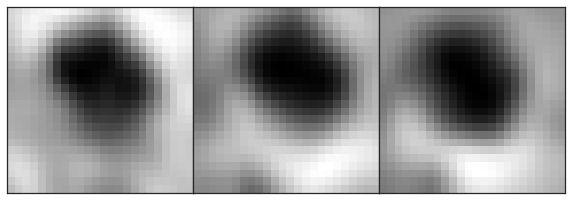

In [254]:
for f,strength in sorted(enumerate(p_f), key=lambda x:x[1], reverse=True):
    #if strength<0.2:
    #    break
    print("%s %d%%" % (all_features[f], strength*100))

x_test_quick = x_test[cls][test_ix]#orig_data_dict[cls][0][np.where(orig_data_dict[cls][1] == indices_f[test_ix])]
hf.draw_slices(x_test_quick)

In [193]:
Z_test_features = ['E106097391_0', 'E104978772_1', '12900535_0', 'E100150242_0', 'E105490014_0', 'E103147618_0', 'E103510187_0', 'E104657225_0', 'E100551966_0', 'E101388602_0', 'E100215900_8', 'E100215900_7', 'E104045692_0', '13104521_0', 'E100383453_0', '12943286_0', '12271995_0', 'E102315724_0', 'E104949189_0', 'E100511083_1', 'E101579471_0', '13018986_1', '13203550_8', '13112385_0', '12712463_0', '12361082_0', '13028374_0', 'E103985934_1', 'E100529980_0', '12042703_3', '12961059_0', 'E105724706_2', 'E100592424_2', 'E103104254_0', 'E104546069_0', 'E101665217_1', '12090000_0', 'E100592424_1', '12961059_1', 'E105474285_0', '12502068_1', 'E100814791_0', 'E102613189_0', 'E105427046_0', 'E102881031_1', 'E102929168_0', 'E102310482_0', 'E102095465_0', 'E101811299_0', 'E104737273_0', '12890053_0', 'E100168661_1', '12637865_0', 'E100168661_2', '12239783_0', '12707781_0', '12706568_1', '12823036_0', '12404081_0', '12365693_1']

x_test = {cls: orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}
Z_test = {cls: orig_data_dict[cls][1][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}

filters_test = {}
features_test = {}
for cls in C.classes_to_include:
    filters_test[cls] = model_dense_outputs.predict(x_test[cls], verbose=False)

In [ ]:
for f_ix in range(num_features):

In [ ]:
def classify_vector(vector, feature_vectors):
    best_feature = -1
    for f_ix, feature_vec in enumerate(feature_vectors):
        if np.dot(vector, feature_vec) < threshold:
            

In [251]:
scaled_filter_results = (filter_results - filter_avgs) / filter_stds

np.amin(filter_results, axis=0)

In [168]:
feature_vectors = np.empty((num_features, num_units))
feature_relevance = np.empty(num_features)
for f_ix in range(num_features):
    feature_vectors[f_ix, :] = np.mean(feature_filters[all_features[f_ix]], axis=0)
    feature_evidence[f_ix] = np.dot(feature_vectors[f_ix], W_eff)

In [ ]:
squashed_filter_results = (filter_results / filter_stds)

Requirements
- feature_vectors * unit_relevance should be maximized

- np.dot(feature_vectors[i], feature_vectors[j]) should be minimized, OR
- vec_distance(feature_vectors[i], feature_vectors[j]) should be maximized for all pairs i,j

- features "turn on / off" specific units; try to minimize the number of units impacted by a given feature

- p(z|x) > .75 for all x manually annotated by z

===
- show % of evidence explained (fraction of sum of contributing units that are captured by features that turn those units on)

## Relevance calculations

In [ ]:
unit_relevance = np.empty(num_units)
for u_ix in range(num_units):
    unit_relevance[u_ix] = np.amax(W_eff[u_ix]) - np.amin(W_eff[u_ix])

In [209]:
filter_results = filter_results*unit_relevance

In [217]:
avg_length = np.mean(np.apply_along_axis(get_length, 1, filter_results*unit_relevance))

In [219]:
np.sum(squash(filter_results[2] * unit_relevance * 2/avg_length)**2)

0.6239091267665856

In [180]:
importlib.reload(im)

<module 'inference_methods' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\inference_methods.py'>

In [192]:
def EM_loop(k, alpha=.8, beta=.3, **kwargs):
    if len(kwargs) == 0:
        W = np.ones((num_features, num_units))
        for f_ix in range(num_features):
            W[f_ix] = feature_filter_means[all_features[f_ix]]
        mu = np.ones(num_units)
        sigma = 5
        a = 5
        b = 3
        theta = np.zeros((num_features, num_features))#scipy.random.normal(size=(num_features, num_features))
    else:
        mu = kwargs['mu']
        sigma = kwargs['sigma']
        W = kwargs['W']
        a = kwargs['a']
        b = kwargs['b']
        theta = kwargs['theta']
    
    print("Initializing probabilities...")
    U = im.get_squashed_X(X, a, b)
    p_z = im.get_p_z(z_states, theta)
    s_states = im.get_s_states(z_states, W, p_z)
    p_x_z = im.get_all_p_x_z(mu, sigma, s_states, U, fixed_indices, z_states)
    p_z_x = im.get_all_p_z_x(p_x_z, p_z)
    
    print("Running EM:")
    for jj in range(k):
        print("   Iteration", jj, end="...")
        print("Updating W, theta...", end="")
        W = im.update_W(mu, W, z_states, U, p_z_x, fixed_indices, alpha)
        theta = im.update_thetas(np.sum(p_z_x, axis=0), z_states_bool, theta, alpha)

        p_z = im.get_p_z(z_states, theta)
        s_states = im.get_s_states(z_states, W, p_z)
        p_z_x = im.get_all_p_z_x(p_x_z, p_z)
        
        print("Updating mu, sigma, a, b...", end="")
        mu = im.update_mus(mu, s_states, U, p_z_x, beta)
        sigma = im.update_sigma(mu, sigma, s_states, U, p_z_x)
        a, b = im.update_ab(mu, a, b, sigma, s_states, X, p_z_x, beta)

        if jj < k-1:
            print("Updating probabilities...")
            U = im.get_squashed_X(X, a, b)
            s_states = im.get_s_states(z_states, W, p_z)
            p_x_z = im.get_all_p_x_z(mu, sigma, s_states, U, fixed_indices, z_states)
            p_z_x = im.get_all_p_z_x(p_x_z, p_z)
            
    return W, theta, mu, sigma, a, b

In [193]:
params = {}

In [154]:
params = {'mu': mu,
'sigma': sigma,
'a': a,
'b': b,
'W': W,
'theta': theta}

print(np.amin(mu), np.amax(mu))
print(np.amin(W), np.amax(W))
print(np.amin(theta), np.amax(theta))
print(sigma)
print(a, b)

-0.6068820855405788 0.4020698107354496
-1.2357424596567832 0.8557082098766997
-0.0009163150682455879 0.011434793765638829
1.9101354005255533
2.0048 1.0032


In [8]:
importlib.reload(im)
im.W_opt_func(np.ravel(W), a_i, b_i, c_i, z_states, W, fixed_indices, U)

<module 'inference_methods' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\inference_methods.py'>

In [150]:
theta = np.zeros((num_features, num_features))

In [194]:
importlib.reload(im)
#W = im.update_W(mu, W, z_states, U, p_z_x, fixed_indices, .5, view_weights=True)
W, theta, mu, sigma, a, b = EM_loop(2, **params)

Initializing probabilities...
Running EM:
   Iteration 0...Updating W, theta...Updating mu, sigma, a, b...Updating probabilities...
   Iteration 1...Updating W, theta...Updating mu, sigma, a, b...

In [144]:
p_z = np.ones(p_z.shape)
p_z_x = im.get_all_p_z_x(p_x_z, p_z)

In [188]:
U = im.get_squashed_X(X, a, b)
p_z = im.get_p_z(z_states, theta)
s_states = im.get_s_states(z_states, W, p_z)
p_x_z = im.get_all_p_x_z(mu, sigma, s_states, U, fixed_indices, z_states)
p_z_x = im.get_all_p_z_x(p_x_z, p_z)

t=time.time()
for _ in range(num_states*10):
    np.nan_to_num(0)
    #pass
print(time.time()-t)

progressive centripetal filling 25%
hyperintense mass on delayed phase 25%
venous washout 25%
infiltrative 25%
lobulated margins 25%
heterogeneous 25%
regular spherical hypointense mass 25%
progressive or concentric enhancement 25%
continuous enhancing rim 25%
thin well-defined walls 25%
arterial enhancement 25%
delayed isointensity 25%
nodular or discontinuous enhancement 25%
hypointense without enhancement 25%


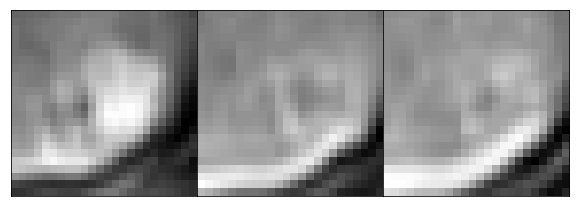

In [190]:
test_ix = 0
#for test_ix in test_indices[5:]:
p_zi_x = np.zeros([num_features])
for f_ix in range(num_features):
    state_ixs = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
    p_zi_x[f_ix] = sum(p_z_x[test_ix, state_ixs])
    #for f,strength in sorted(enumerate(p_zi_x), key=lambda x:x[1], reverse=True):
    #    output[z] = output[z] + [f, strength]
#break

for f,strength in sorted(enumerate(p_zi_x), key=lambda x:x[1], reverse=True):
    if strength<0.2:
        break
    print("%s %d%%" % (all_features[f], strength*100))

for cls in C.classes_to_include:
    x_test_quick = orig_data_dict[cls][0][np.where(orig_data_dict[cls][1] == indices_f[test_ix])]
    if len(x_test_quick) > 0:
        break
hf.draw_slices(x_test_quick[0])

header = ['filter_num']
for cls in C.classes_to_include:
    header += [f+"_"+cls for f in features_by_cls[cls]]

with open('E:\\feature_filters.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for f_num in range(100):
        writer.writerow([f_num] + [feature_filters[f][f_num] for cls in features for f in features_by_cls[cls]])

In [98]:
Z_test_features = ['E106097391_0', 'E104978772_1', '12900535_0', 'E100150242_0', 'E105490014_0', 'E103147618_0', 'E103510187_0', 'E104657225_0', 'E100551966_0', 'E101388602_0', 'E100215900_8', 'E100215900_7', 'E104045692_0', '13104521_0', 'E100383453_0', '12943286_0', '12271995_0', 'E102315724_0', 'E104949189_0', 'E100511083_1', 'E101579471_0', '13018986_1', '13203550_8', '13112385_0', '12712463_0', '12361082_0', '13028374_0', 'E103985934_1', 'E100529980_0', '12042703_3', '12961059_0', 'E105724706_2', 'E100592424_2', 'E103104254_0', 'E104546069_0', 'E101665217_1', '12090000_0', 'E100592424_1', '12961059_1', 'E105474285_0', '12502068_1', 'E100814791_0', 'E102613189_0', 'E105427046_0', 'E102881031_1', 'E102929168_0', 'E102310482_0', 'E102095465_0', 'E101811299_0', 'E104737273_0', '12890053_0', 'E100168661_1', '12637865_0', 'E100168661_2', '12239783_0', '12707781_0', '12706568_1', '12823036_0', '12404081_0', '12365693_1']

x_test = {cls: orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}
Z_test = {cls: orig_data_dict[cls][1][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}

# Least squares approach
Theta = np.array([feature_filter_means[f] for f in all_features])
Theta = np.transpose(Theta, (1,0))

filters_test = {}
features_test = {}
for cls in C.classes_to_include:
    filters_test[cls] = model_dense_outputs.predict(x_test[cls], verbose=False)
    filters_test[cls] = (filters_test[cls] - filter_avgs) / filter_stds
    features_test[cls] = np.linalg.lstsq(Theta, np.transpose(filters_test[cls], (1,0)))[0]
    #filters_test[cls] = np.apply_along_axis(lambda x: x / filter_avgs, 1, filters_test[cls])

In [33]:
from sklearn.decomposition import FactorAnalysis

In [99]:
fa = FactorAnalysis(10)

In [36]:
filter_results.shape

(637, 100)

In [87]:
def covar_to_corr(covar):
    A = np.diag(np.diag(covar)**(-0.5))
    return np.matmul(np.matmul(A, covar), A)

In [90]:
corr = covar_to_corr(dummy_fa.get_covariance())

In [ ]:
np.linalg.eigvals(corr - np.linalg.pinv(np.diag(np.diag(np.linalg.pinv(corr)))))

In [ ]:
def get_cutoff_eigenval()

In [65]:
dummy = np.random.normal(size=filter_results.shape)
dummy_fa = FactorAnalysis()
dummy_fa.fit(dummy)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [ ]:
np.linalg.eigvals(dummy_fa.get_covariance())

In [101]:
sum(np.linalg.eigvals(fa.get_covariance()) > np.mean(np.linalg.eigvals(dummy_fa.get_covariance())))

8

In [100]:
fa.fit(filter_results)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=10,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [ ]:
np.linalg.eigvals()

In [53]:
x=3
fa.get_covariance()[x,x] - fa.noise_variance_[x]

0.89081373261106078

cls = "colorectal"
x_test_quick = orig_data_dict[cls][0][np.where(orig_data_dict[cls][1] == "E105724706_2.npy")]
x_test_quick = orig_data_dict["fnh"][0][np.where(orig_data_dict["fnh"][1] == "E104189184_0.npy")]
filters_quick = model_dense_outputs.predict(x_test_quick, verbose=False)

In [ ]:
img_num = 0
evidence = {}

for f in all_features:
    evidence[f + "/" + str(cls_features[f])] = cnna.get_evidence_strength(feature_filters[f], filters_quick[0])#filters_test[true_cls][img_num])
    #max_strength = max(max_strength, evidence[f + "/" + str(cls_features[f])])

#for f in evidence:
#    evidence[f] /= max_strength
print("Detected features:")
for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True)[:5]:
    #if strength > 1:
    print("- " + f, "- %d%%" % (strength*100))

hf.plot_section_auto(x_test_quick[0])#[true_cls][img_num])

In [101]:
output = {}
for cls in C.classes_to_include:
    for img_num in range(len(filters_test[cls])):
        z = Z_test[cls][img_num]
        x = np.expand_dims(x_test[cls][img_num], axis=0)
        evidence = {}
        
        output[z] = [cls]
        
        preds = model.predict(x, verbose=False)[0]
        for pred_cls, pred_conf in sorted(zip(C.classes_to_include, preds), key=lambda x:x[1], reverse=True)[:2]:
            output[z] = output[z] + [pred_cls]
        
        #for f in all_features:
        #    evidence[f + "/" + str(cls_features[f])] = get_evidence_strength(feature_filters[f], filters_test[cls][img_num])
        
        for i in range(len(all_features)):
            evidence[all_features[i] + "/" + str(cls_features[all_features[i]])] = features_test[cls][i, img_num]
        
        f1='infiltrative'
        f2='lobulated margins'
        if evidence[f1 + "/" + str(cls_features[f1])] < evidence[f2 + "/" + str(cls_features[f2])]:
            evidence.pop(f1 + "/" + str(cls_features[f1]))
        else:
            evidence.pop(f2 + "/" + str(cls_features[f2]))
        
        for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True):
            output[z] = output[z] + [f, strength]

In [104]:
with open('E:\\filters_pred5.csv', 'w', newline='') as csvfile:
    header = ['img_fn', 'agreement1', 'agreement2', 'true_cls', 'pred_cls1', 'pred_cls2'] + \
            [s for i in range(len(all_features)) for s in ['feature_%d' % i,'strength_%d' % i]]
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for z_num in range(len(Z_test_features)):
        writer.writerow([Z_test_features[z_num]] + [output[Z_test_features[z_num]][0] in output[Z_test_features[z_num]][3], \
                        output[Z_test_features[z_num]][0] in output[Z_test_features[z_num]][5]] + output[Z_test_features[z_num]])

In [60]:
df = pd.read_excel("E:\\filters_pred3.xlsx")

In [75]:
agree = 0
for _,row in df.iterrows():
    if row["pred_cls1"] in row["feature_1"]:
        agree += 1
print(agree/60)

52
